In [1]:

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 96% 318M/331M [00:00<00:00, 493MB/s]
100% 331M/331M [00:00<00:00, 532MB/s]


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2


In [4]:
!unzip utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [5]:
dir_name  ="/content/images"


In [6]:
train_images = tf.keras.preprocessing.image_dataset_from_directory(
    dir_name,
    batch_size = 32,
    image_size = (128,128),
    seed=123,
    label_mode = None

)


train_images = train_images.map(lambda x: ((x/127.5) - 1)) # same as tanh [-1 to 1] range
# train_images = train_images.map(lambda x: x/255. )



Found 23708 files.


In [7]:
print(tf.is_tensor(train_images))

False


In [8]:
images = next(train_images.as_numpy_iterator())

In [9]:
images.shape

(32, 128, 128, 3)

In [10]:
print(type(train_images))

<class 'tensorflow.python.data.ops.map_op._MapDataset'>


(32, 128, 128, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>


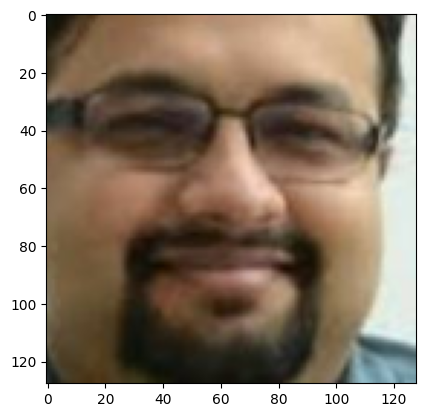

In [11]:
for images in train_images:
  print(images.shape)
  print(type(images))
  images = (images+1)/2.
  plt.imshow(images[30])
  break

In [12]:
len(train_images)

741

In [13]:
limited_images = train_images.take(50)
print(len(limited_images))

50


In [14]:
for i in limited_images:
  print(i.shape)
  break

(32, 128, 128, 3)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

limited_images = limited_images.prefetch(buffer_size=AUTOTUNE)



In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *

def make_generator():  # upsample the image

  generator = Sequential([
      Dense(8*8*128,use_bias = False,input_shape=(100,)),
      BatchNormalization(),
      LeakyReLU(),

      Reshape((8,8,128)),

      Conv2DTranspose(256,(5,5),strides = (2,2),padding="same",use_bias=False),
      BatchNormalization(),
      LeakyReLU(),

      Conv2DTranspose(128,(5,5),strides = (2,2),padding="same",use_bias=False),
      BatchNormalization(),
      LeakyReLU(),

      Conv2DTranspose(64,(5,5),strides = (2,2),padding="same",use_bias=False),
      BatchNormalization(),
      LeakyReLU(),

      Conv2DTranspose(32,(5,5),strides = (2,2),padding="same",use_bias=False),
      BatchNormalization(),
      LeakyReLU(),

      Conv2D(3,(5,5),padding="same",activation="tanh")  # this is output layer there for 128,128,3
                                                        #   and all pixel values are in range [-1,1]



  ])

  return generator


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(1, 128, 128, 3)


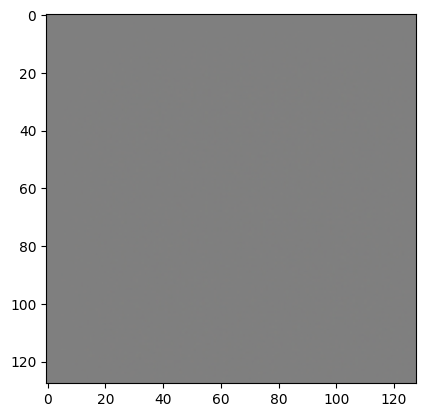

In [17]:
noise = tf.random.normal([1,100])
generator = make_generator()

random_image = generator(noise,training=False)
random_image = (random_image + 1)/2.0
print(random_image.shape)
plt.imshow(random_image[0])

In [18]:
# now discriminator

def make_discriminator(): # traditional cnn model for classification between real and fake image
  discriminator = Sequential([
      Input(shape=(128,128,3)),

      Conv2D(256,(5,5),strides=(2,2),padding="same"),
      LeakyReLU(),
      Dropout(0.3),

      Conv2D(128,(5,5),strides=(2,2),padding="same"),
      LeakyReLU(),
      Dropout(0.3),

      Flatten(),

      Dense(1)  # we are sending raw output

  ])

  return discriminator



In [19]:
discriminator = make_discriminator()


In [20]:
# losses

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # this true means that we apply sigmoid and log in this and


In [21]:
gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)

In [22]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [23]:
def discriminator_loss(real_output, fake_output):
  real_loss =  cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)

  total_loss = real_loss + fake_loss

  return total_loss

In [24]:
def train_step(r_images):
  noise = tf.random.normal([32,100])


  with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:

    generated_images = generator(noise,training = True)

    real_output = discriminator(r_images,training = True)

    fake_output = discriminator(generated_images,training = True)
    # we forward propogated on both the models

    # now calculate the gradients

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output,fake_output)


#  here we have found for each value dL/d... in both the model
  gen_gradient = gen_tape.gradient(gen_loss,generator.trainable_variables)
  dis_gradient = dis_tape.gradient(disc_loss,discriminator.trainable_variables)

  # update the weights / or simply apply gradients using learning rate and gradient which we found

  gen_opt.apply_gradients(
      zip(gen_gradient,generator.trainable_variables)
  )

  disc_opt.apply_gradients(
      zip(dis_gradient,discriminator.trainable_variables)
  )

  return gen_loss,disc_loss


In [ ]:
def train(epochs,dataset):
  
  
  for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}")
        for step, images in enumerate(dataset):
            gen_loss, disc_loss = train_step(images)
            if step % 100 == 0:
                print(f"Step {step}: Gen Loss = {gen_loss.numpy():.4f}, Real Loss = {disc_loss.numpy():.4f}")

  # for epoch in range(epochs):
  #   print(f"Epoch {epoch+1}")

  #   for images in dataset:
  #     g_loss,d_loss = train_step(images)
  #     print(f"generator_loss = {g_loss} , discriminator_loss = {d_loss}")
      
      
      


In [30]:
train(50,limited_images)

Epoch 1
generator_loss = 2.6627438068389893 , discriminator_loss = 0.3936997056007385
generator_loss = 2.9567227363586426 , discriminator_loss = 0.6106929779052734
generator_loss = 2.9147183895111084 , discriminator_loss = 0.24795401096343994
generator_loss = 2.2767844200134277 , discriminator_loss = 0.41278076171875
generator_loss = 2.9071502685546875 , discriminator_loss = 0.2658582627773285
generator_loss = 2.6961562633514404 , discriminator_loss = 0.47658705711364746
generator_loss = 2.4699487686157227 , discriminator_loss = 0.34803271293640137
generator_loss = 2.9254775047302246 , discriminator_loss = 0.3494689464569092
generator_loss = 2.7082910537719727 , discriminator_loss = 0.4620336890220642
generator_loss = 2.8568248748779297 , discriminator_loss = 0.3391704559326172
generator_loss = 3.073066473007202 , discriminator_loss = 0.5170912742614746
generator_loss = 2.4712069034576416 , discriminator_loss = 0.6436148285865784
generator_loss = 2.7860517501831055 , discriminator_loss

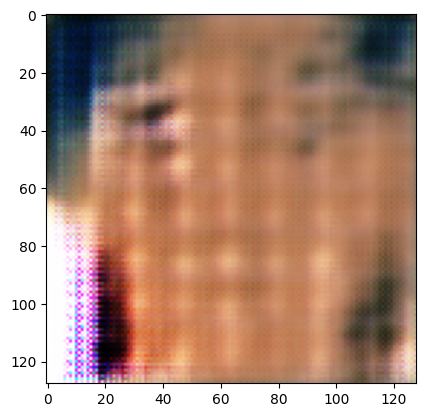

In [29]:
# after 50 epochs

new_noise = tf.random.normal([1,100])
new_random_img = generator(new_noise,training=False)

new_random_img = (new_random_img + 1) / 2.
plt.imshow(new_random_img[0])

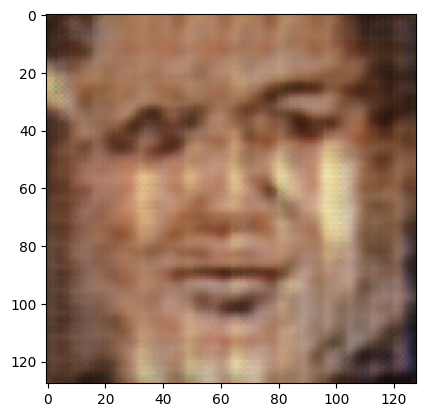

In [31]:
# after 100 epochs

new_noise = tf.random.normal([1,100])
new_random_img = generator(new_noise,training=False)

new_random_img = (new_random_img + 1) / 2.
plt.imshow(new_random_img[0])

In [32]:
generator.save("generator.h5")
discriminator.save("discriminator.h5")

In [ ]:
generator.save("generator.keras")
discriminator.save("discriminator.keras")